In [44]:
#from get_graph_func import get_graphs
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

In [49]:
#этот файл получен в предыдущем ноутбуке (Data Prepation)
for_churn = pd.read_excel('for_churn.xlsx')[['report_dt', 'segment', 'state', 'city', 'active','become churn', 'new', 'reactivated', 'remain churn', 'sales','orders_cnt']]

#у меня не получилось сделать красиво через импорт из файла:((, поэтому функция здесь(
def get_graphs(for_churn, segment: str = None, state: str = None, city: str = None):

    if (segment is None) & (state is None) & (city is None):
        filtered_churn = for_churn.groupby('report_dt').sum().reset_index()
        text = 'Total'
    else:
        segment_filter = (lambda x: '' if x is None else f"segment == '" + x + "'")(segment)
        state_filter = (lambda x: '' if x is None else f"state == '" + x + "'")(state)
        city_filter = (lambda x: '' if x is None else f"city == '" + x + "'")(city)

        text = ' ,'.join([x for x in [city, state, segment] if x is not None])
        r = ' & '.join([x for x in [city_filter, state_filter, segment_filter] if len(x) > 0])
        filtered_churn = for_churn.query(r).groupby('report_dt').sum().reset_index()

    filtered_churn['active_shift'] = filtered_churn['active'].shift(1)
    filtered_churn['active_avg'] = (filtered_churn['active'] + filtered_churn['active_shift']) / 2
    filtered_churn['churn_rate'] = filtered_churn['become churn'] / filtered_churn['active_avg']
    filtered_churn['reactivation_rate'] = filtered_churn['reactivated'] / filtered_churn['active_avg']
    filtered_churn['avg_order'] = filtered_churn['sales'] / filtered_churn['orders_cnt']

    filtered_churn['year'] = filtered_churn['report_dt'].dt.year.astype('int')
    filtered_churn['churn'] = [1 - i for i in filtered_churn['churn_rate']]
    filtered_churn['reactivation'] = [1 - i for i in filtered_churn['reactivation_rate']]

    print('-------------ГОДОВАЯ ДИНАМИКА-------------')
    print('\n')
    test_1 = filtered_churn.groupby('year').prod()['churn'].reset_index()
    test_1['churn'] = (round(100 - test_1['churn'] * 100, 1)).astype('str') + '%'
    test_1 = test_1.T
    test_1.columns = test_1.iloc[0].astype('int')
    test_1 = test_1[1:]
    display(test_1)

    test_1 = filtered_churn.groupby('year').prod()['reactivation'].reset_index()
    test_1['reactivation'] = round(100 - test_1['reactivation'] * 100, 1).astype('str') + '%'
    test_1 = test_1.T
    test_1.columns = test_1.iloc[0].astype('int')
    test_1 = test_1[1:]
    display(test_1)

    test_1 = filtered_churn.groupby('year').sum()['sales'].reset_index()
    test_1['sales'] = test_1['sales'].astype('int')
    test_1 = test_1.T
    test_1.columns = test_1.iloc[0].astype('int')
    test_1 = test_1[1:]
    display(test_1)

    test_1 = filtered_churn.groupby('year').sum()['orders_cnt'].reset_index()
    test_1['orders_cnt'] = test_1['orders_cnt'].astype('int')
    test_1 = test_1.T
    test_1.columns = test_1.iloc[0].astype('int')
    test_1 = test_1[1:]
    display(test_1)

    test_1 = filtered_churn.groupby('year').mean()['avg_order'].reset_index()
    test_1['avg_order'] = round(test_1['avg_order'], 1)
    test_1 = test_1.T
    test_1.columns = test_1.iloc[0].astype('int')
    test_1 = test_1[1:]
    display(test_1)

    test_1 = filtered_churn.groupby('year').sum()['new'].reset_index()
    test_1['new'] = test_1['new'].astype('int')
    test_1 = test_1.T
    test_1.columns = test_1.iloc[0].astype('int')
    test_1 = test_1[1:]
    display(test_1)

    print('\n')
    print('-------------МЕСЯЧНАЯ ДИНАМИКА-------------')
    print('\n')
    fig, ax = plt.subplots(3, 2, figsize=(30, 20))

    ax[0, 0].plot(filtered_churn[['report_dt', 'churn_rate']].sort_values(by=['report_dt']).set_index('report_dt'))
    ax[0, 0].set_title(f'Churn Rate, % for {text}')

    dates = filtered_churn['report_dt']
    data_test = filtered_churn['churn_rate']

    for x, y in zip(dates, data_test):
        if y == 0:
            pass
        else:
            label = f'{round(y * 100, 1)}'
            ax[0, 0].annotate(label,
                              (x, y),
                              textcoords="offset points",
                              xytext=(-1, -10),
                              ha='center')

    ax[0, 1].plot(filtered_churn[['report_dt', 'reactivation_rate']].set_index('report_dt'))
    ax[0, 1].set_title(f'Reactivation Rate, % for {text}')

    dates = filtered_churn['report_dt']
    data_test = filtered_churn['reactivation_rate']

    for x, y in zip(dates, data_test):
        if y == 0:
            pass
        else:
            label = f'{round(y * 100, 1)}'
            ax[0, 1].annotate(label,
                              (x, y),
                              textcoords="offset points",
                              xytext=(-1, -10),
                              ha='center')

    ax[1, 0].plot(filtered_churn[['report_dt', 'sales']].set_index('report_dt'))
    ax[1, 0].set_title(f"Sales Volume'000 for {text}")

    dates = filtered_churn['report_dt']
    data_test = filtered_churn['sales']

    for x, y in zip(dates, data_test):
        if y == 0:
            pass
        else:
            label = int(y / 1000)
            ax[1, 0].annotate(label,
                              (x, y),
                              textcoords="offset points",
                              xytext=(-1, -10),
                              ha='center')

    ax[1, 1].plot(filtered_churn[['report_dt', 'orders_cnt']].set_index('report_dt'))
    ax[1, 1].set_title(f'Orders Count for {text}')

    dates = filtered_churn['report_dt']
    data_test = filtered_churn['orders_cnt']

    for x, y in zip(dates, data_test):
        if y == 0:
            pass
        else:
            label = int(y)
            ax[1, 1].annotate(label,
                              (x, y),
                              textcoords="offset points",
                              xytext=(-1, -10),
                              ha='center')

    ax[2, 0].plot(filtered_churn[['report_dt', 'avg_order']].set_index('report_dt'))
    ax[2, 0].set_title(f'Average Order for {text}')

    dates = filtered_churn['report_dt']
    data_test = filtered_churn['avg_order']

    for x, y in zip(dates, data_test):
        if y == 0:
            pass
        else:
            label = int(y)
            ax[2, 0].annotate(label,
                              (x, y),
                              textcoords="offset points",
                              xytext=(-1, -10),
                              ha='center')

    ax[2, 1].plot(filtered_churn[['report_dt', 'new']].set_index('report_dt'))
    ax[2, 1].set_title(f'New clients for {text}')

    dates = filtered_churn['report_dt']
    data_test = filtered_churn['new']

    for x, y in zip(dates, data_test):
        if y == 0:
            pass
        else:
            label = int(y)
            ax[2, 1].annotate(label,
                              (x, y),
                              textcoords="offset points",
                              xytext=(-1, -10),
                              ha='center')
    plt.show()

## Сводная информация

Чтобы получить сводную информацию по интересующему разрезу необходимо вызвать функцию **get_graphs**

В функцию передаются параметры: источник данных, сегмент, штат и город

get_graphs(for_churn, segment: str = None, state: str = None, city: str = None)


Примеры вызова:
 - get_graphs(for_churn, segment = 'Consumer', state = 'Ohio')
 - get_graphs(for_churn, segment = 'Consumer')
 - get_graphs(for_churn)
 
 
**Как считается отток:**

Cтатусы клиента:

- new - если клиент активен в первый раз
- active - если клиент активен или неактивен в течение 0-6м
- become churn - если клиент неактивен более, 7 месяцев (первый месяц оттока)
- remain churn - если клиент остается неактивным более, чем 7 месяцев
- reactivated - если клиент вернулся в активность из состояния become churn/remain churn

Выбран период 7 месяцев, так как клиенты в среднем реактивируются через 6 месяцев. Таким образом, предполагаем - если клиент не совершил покупку через 6 месяцев молчания - он оттек

**Ежемесячные показатели:**

churn_rate = become_churn/(avg(active_previous, active))

reactivated_rate = reactivated/(avg(active_previous, active))


**Годовые показатели:**

churn_rate = 1 - (1-churn_rate_m1) * (1-churn_rate_m2) * (1-churn_rate_m3) * ... * (1-churn_rate_m12)

reactivation_rate = 1 - (1-reactivated_rate_m1) * (1-reactivated_rate_m2) * (1-reactivated_rate_m3) * ... * (1-reactivated_rate_m12)

**Ответ:** Видим, что годовой отток снижается (57.7% в 2017 vs 67.8% в 2016), гипотеза руководителя не подтвердилась

В инструменте для руководителя также вывожу помесячную динамику по сопутсвующим показателям, по которым могут возникнуть вопросы:

- реактивация клиентов - может возникнуть вопрос: За счет чего растет клиентская активная база? За счет новичков или реактиваций? А как мы вообще работаем с отточными клиентами - есть ли смысл с ними работать, они уходят навсегда или реактивируются?
- показатели продаж (объем продаж, кол-во заказов, средний чек) - может возникнуть вопрос: У нас падает отток в головах, а что происходит в продажах? Может оставшиеся больше покупают? Больше - в количестве или объемам? А какой средний чек? Какая по нему динамика?
- new (новые клиенты) - может возникнуть вопрос - Как мы можем влиять на нашу базу? Нам нужно работать на удержание или на привлечение новых клиентов?
- динамику вывожу помесячную, чтобы была картина по сезонности (Например, видим, что пики по продажам приходятся на январь, после чего клиенты уходят в отток (пики сезонности оттока в июне))

-------------ГОДОВАЯ ДИНАМИКА-------------




year,2014,2015,2016,2017
churn,32.7%,73.3%,67.8%,57.7%


year,2014,2015,2016,2017
reactivation,7.4%,60.2%,68.5%,61.2%


year,2014,2015,2016,2017
sales,484247,470532,609205,649385


year,2014,2015,2016,2017
orders_cnt,969,1038,1315,1463


year,2014,2015,2016,2017
avg_order,470.2,453.6,464.0,450.5


year,2014,2015,2016,2017
new,595,136,51,11




-------------МЕСЯЧНАЯ ДИНАМИКА-------------




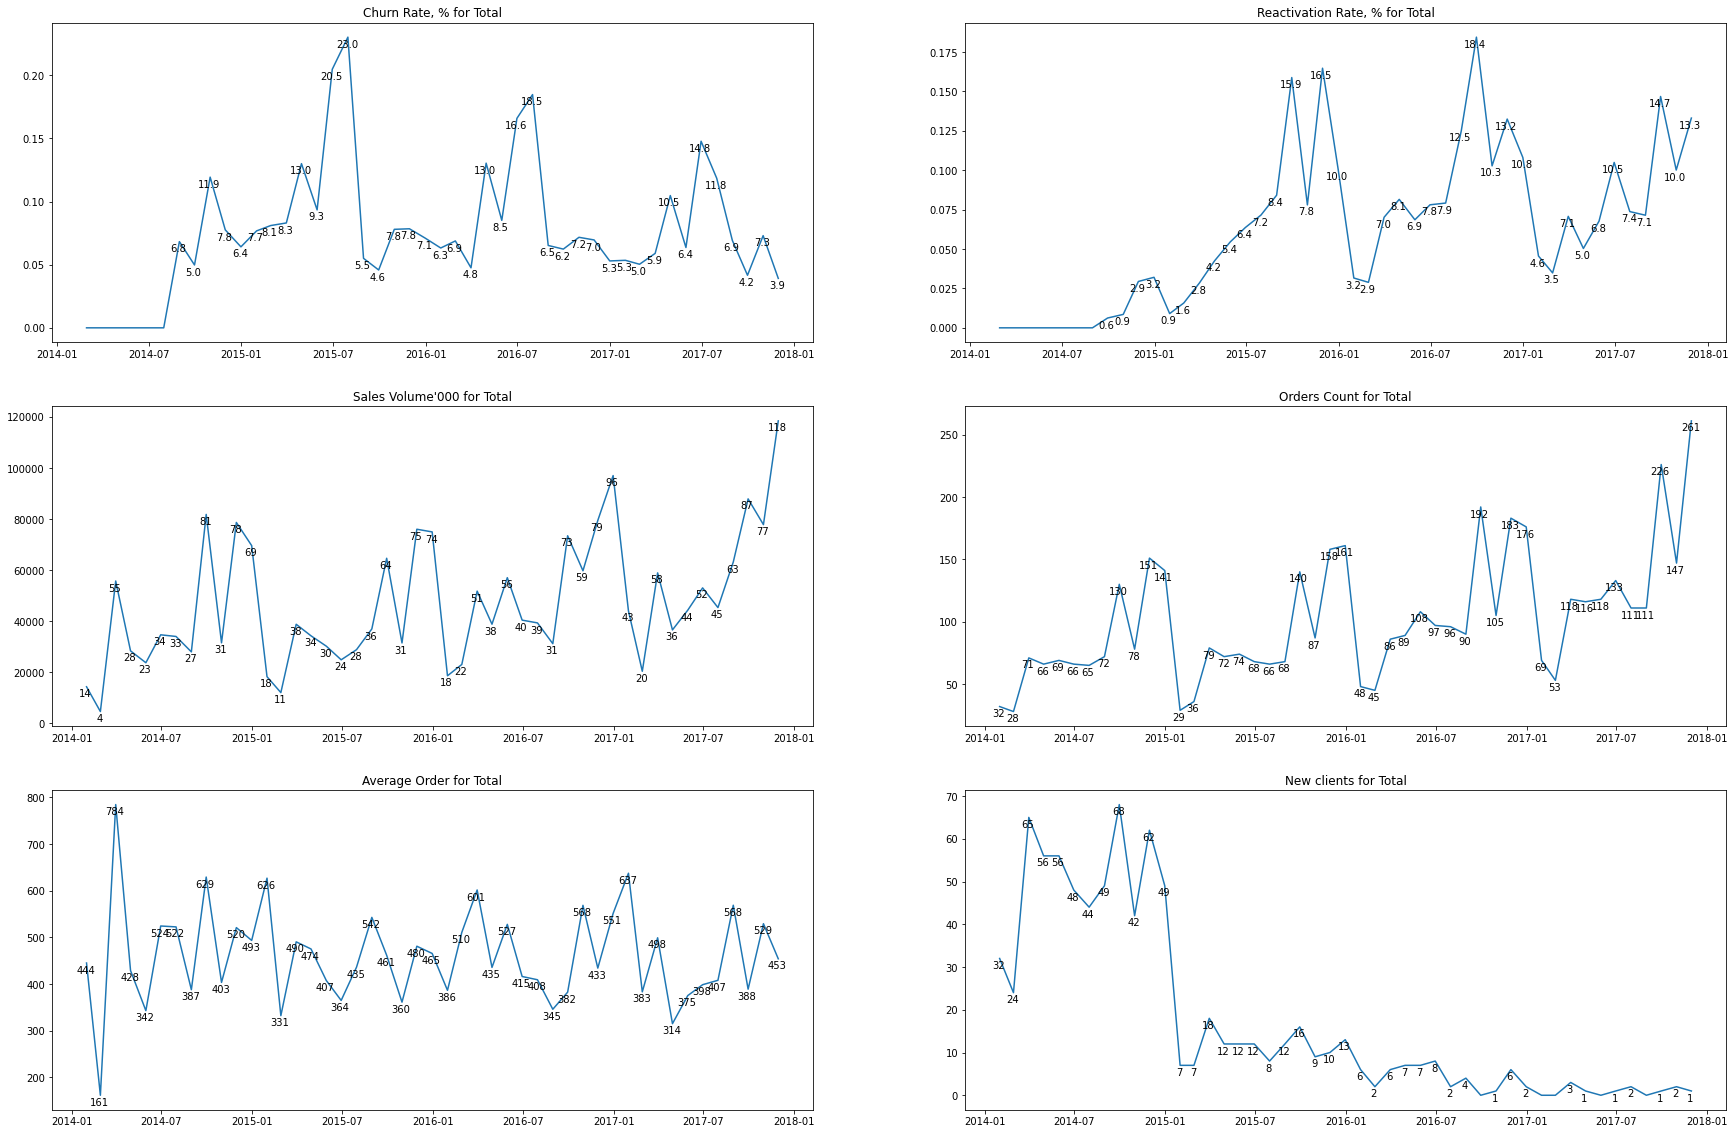

In [50]:
get_graphs(for_churn)

-------------ГОДОВАЯ ДИНАМИКА-------------




year,2014,2015,2016,2017
churn,32.6%,73.9%,68.6%,58.2%


year,2014,2015,2016,2017
reactivation,7.7%,61.9%,69.1%,61.4%


year,2014,2015,2016,2017
sales,266096,266535,296863,281672


year,2014,2015,2016,2017
orders_cnt,524,535,651,751


year,2014,2015,2016,2017
avg_order,455.7,552.9,449.8,376.9


year,2014,2015,2016,2017
new,311,64,27,7




-------------МЕСЯЧНАЯ ДИНАМИКА-------------




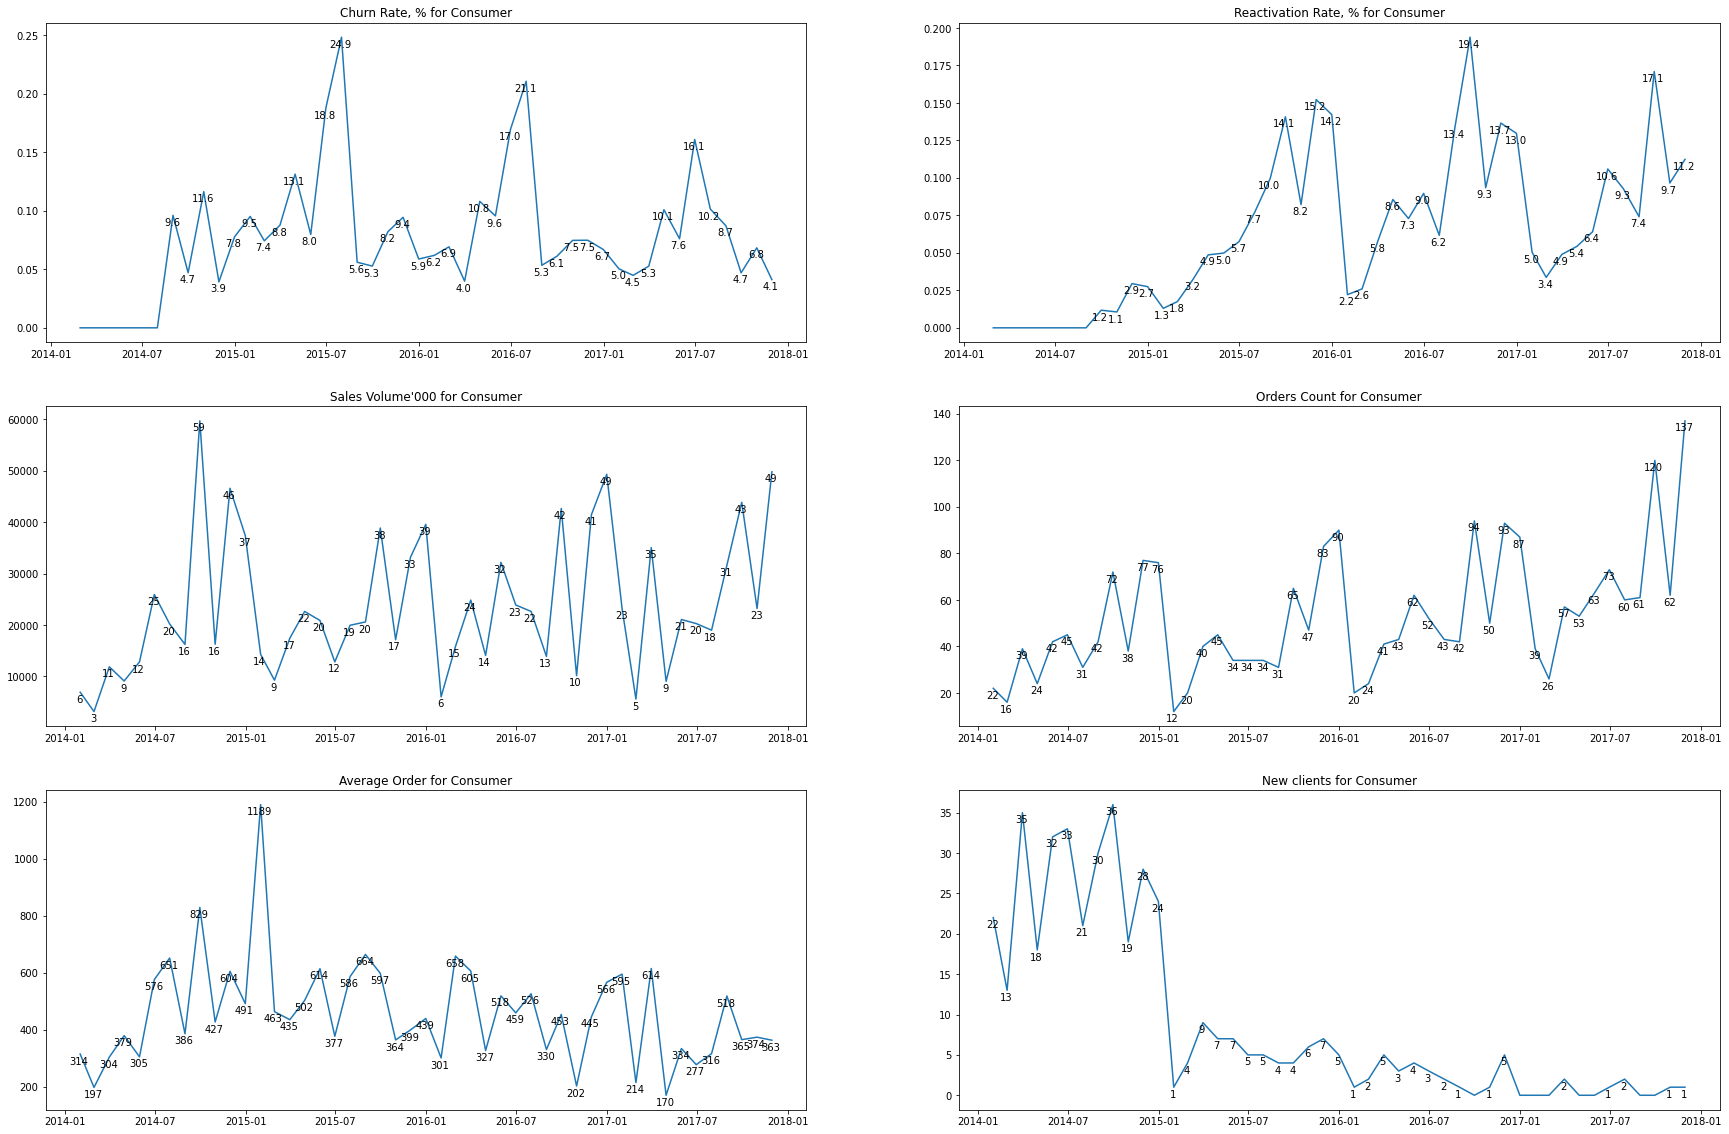

In [52]:
get_graphs(for_churn, segment = 'Consumer')